Import the key modules and set parameters

In [1]:
from caveclient import CAVEclient
from meshparty import trimesh_io, trimesh_vtk
import cloudvolume 
import numpy as np

In [2]:
client = CAVEclient('minnie65_public')
# specify the materialization version, for consistency across time\n",
client.materialize.version = 117

## What is a Mesh?
A mesh is a set of vertices connected via triangular faces to form a 3 dimensional representation of the outer membrane of a neuron, glia or nucleus.

### Meshes can either be static or dynamic:
##### Static:
- pros: smaller files thus easier to work with, multiple levels of detail (lod) which can be accessed (example below)
- cons: may include false gaps and merges from self contacts, updated less frequently

##### Dynamic:
- pros: highly detailed thus more reflective of biological reality and backed by proofreading infrastructure CAVE (Connectome Annotation Versioning Engine)
- cons: much larger files, only one level of detail

In [3]:
# to access dynamic meshes, you can query the segmentation source from the info client
client.info.segmentation_source()

'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public'

In [4]:
# this can be used to initialize a cloudvolume object
cv = cloudvolume.CloudVolume(client.info.segmentation_source(), progress=False, use_https=True)
# which, given a root_id, can be used to get a mesh
# cloud volume returns a dictionary with the neuron segment id as the key 
# and the mesh as the value
example_cell_id = 864691135474648896
mesh = cv.mesh.get(example_cell_id)[example_cell_id]

In [7]:
# we can check the size of the mesh like so
# vertices are Nx3 x,y,z positions in nm
# faces are Kx3 i,j,k indices into vertices that describe triangles
mesh.vertices.shape, mesh.faces.shape


((1698627, 3), (3388543, 3))

Since downloading meshes can take some time, particularly for these dynamic meshes,
it is convient to cache them on disk.     
     
To facilitate the analysis of meshes, we developed a package called MeshParty that we will use here to enable a cache.

In [5]:
# to enable a cache, create a MeshMeta object
mm = trimesh_io.MeshMeta(cv_path = client.info.segmentation_source(),
                         disk_cache_path='minnie65_meshes',
                         map_gs_to_https=True)

You can get a mesh like this and it will be cached in memory and in disk in case you need it again.    
Restart the kernel and run the below cells again to see the difference.        
You'll find the mesh file saved as an hdf5 file in the "minnie65_v117_meshes"
subdirectory

In [8]:
mesh = mm.mesh(seg_id=example_cell_id)

The MeshParty object has more useful properties and attributes
such as a scipy.csgraph sparse graph object (mesh.csgraph) and a networkx 
graph object (mesh.nxgraph) 

Read more about what you can do with MeshParty on its [Documentation](https://meshparty.readthedocs.io/en/latest/?badge=latest).

In particular it lets you associate skeletons, and annotations onto the mesh into a "meshwork" object. 
    
The meshes that are available in the visualization on micronsexplorer are faster because they are static and have been downsampled multiple times. However, this comes with the drawback of being less biologically accurate as stated above.

In [9]:
# we can access one of these downsampled static meshes here:
# note you need the use_https option here or else cloudvolume will try to use your google credentials
# to access the bucket, and you don't have access to the bucket interface, just anonymous downloading
# cv = cloudvolume.CloudVolume("precomputed://gs://iarpa_microns/minnie/minnie65/seg_m943", use_https=True)

cv = cloudvolume.CloudVolume("precomputed://gs://iarpa_microns/minnie/minnie65/seg", use_https=True)

In [10]:
# the cloud volume interface is the same but it is a faster initial download 
mesh = cv.mesh.get(example_cell_id, lod=2)[example_cell_id]

100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


In [11]:
# as you can see the meshes aren't exactly the same as before. They because they have not been downsampled
mesh.vertices.shape, mesh.faces.shape

((101194, 3), (192476, 3))

In addition, the flat meshes are available in 3 levels of detail, this covers two orders of magnitude of detail
which is what neuroglancer leverages to efficiently load the data at the resolution necessary to render the current scene.  

In [12]:
for lod in range(4):
    mesh = mesh = cv.mesh.get(example_cell_id, lod=lod)[example_cell_id]
    print(f"level of detail {lod}: n_verts: {mesh.vertices.shape[0]} n_faces: {mesh.faces.shape[0]}")

100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


level of detail 0: n_verts: 2017003 n_faces: 3976580


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


level of detail 1: n_verts: 575851 n_faces: 1121653


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


level of detail 2: n_verts: 101194 n_faces: 192476


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

level of detail 3: n_verts: 23099 n_faces: 42211


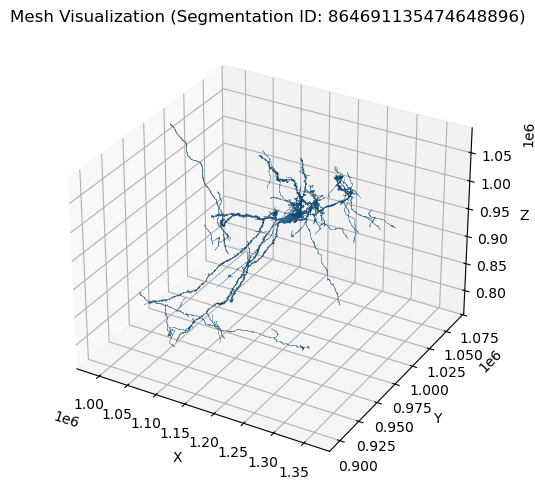

Mesh Information:
Number of vertices: 23099
Number of faces: 42211
Segmentation ID: 864691135474648896


In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
                triangles=mesh.faces)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Mesh Visualization (Segmentation ID: {example_cell_id})')

plt.tight_layout()
plt.show()

# Print mesh information
print(f"Mesh Information:")
print(f"Number of vertices: {mesh.vertices.shape[0]}")
print(f"Number of faces: {mesh.faces.shape[0]}")
print(f"Segmentation ID: {example_cell_id}")